In [29]:
import pandas as pd
import re

# Load data
data = pd.read_csv('code/results/res_20240313_173822/execution_times.csv')

# Remove rows with NaN values
data = data.dropna()

# Function to extract numeric part from time strings
def extract_time(s):
    m, s = re.match(r'(\d+)m(\d+\.\d+)s', s).groups()
    return int(m) * 60 + float(s)

# Apply the function to 'real', 'user', 'sys' columns and convert to float
for col in ['real', 'user', 'sys']:
    data[col] = data[col].apply(extract_time).astype(float)

# Sum 'user' and 'sys' columns to a new column 'cpu_time'
data['cpu_time'] = data['user'] + data['sys']

# Rename 'real' column to 'real_time'
data = data.rename(columns={"real": "real_time"})

# Extract the base filename
data['base_filename'] = data['filename'].str.extract(r'(.*?)(?=_\d+|$)')

# Group by base_filename and calculate mean and standard deviation
mean_result = data.groupby('base_filename')[['real_time', 'cpu_time']].mean()
median_result = data.groupby('base_filename')[['real_time', 'cpu_time']].median()
std_result = data.groupby('base_filename')[['real_time', 'cpu_time']].std()

# Rename columns in standard deviation results
median_result = median_result.rename(columns={"real_time": "real_time_median", "cpu_time": "cpu_time_median"})
std_result = std_result.rename(columns={"real_time": "real_time_std", "cpu_time": "cpu_time_std"})

# Join mean and standard deviation results
result = pd.concat([median_result, mean_result,  std_result], axis=1)

display(result)

,real_time_median,cpu_time_median,real_time,cpu_time,real_time_std,cpu_time_std
base_filename,,,,,,
query1a_bigmv,17.0900,0.0550,18.3000,0.0560,3.776538,0.003091
query1a_clean,23.6270,0.0505,23.6744,0.0503,0.482438,0.001567
query1a_indexed,22.5195,0.0575,22.6163,0.0605,0.317176,0.009823
query1a_mv,0.0925,0.0475,0.0968,0.0474,0.010229,0.002119
query3a_bigmv,17.3410,0.0565,17.5648,0.0573,1.953066,0.004945
query3a_clean,6.1875,0.0470,6.1991,0.0469,0.109455,0.001197
query3a_indexed,0.0600,0.0480,0.0760,0.0482,0.024074,0.002573
query3a_mv,0.0520,0.0440,0.0530,0.0439,0.003367,0.000738


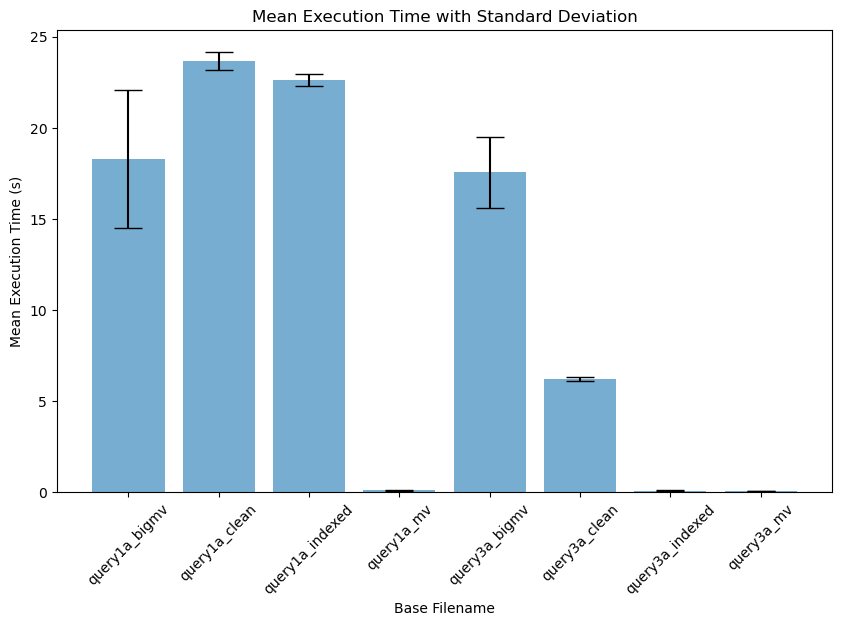

In [23]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a bar plot for 'real' column with 'real_std' as error bars
plt.bar(result.index, result['real_time'], yerr=result['real_time_std'], alpha=0.6, capsize=10)

# Set plot title and labels
plt.title('Mean Execution Time with Standard Deviation')
plt.xlabel('Base Filename')
plt.ylabel('Mean Execution Time (s)')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()

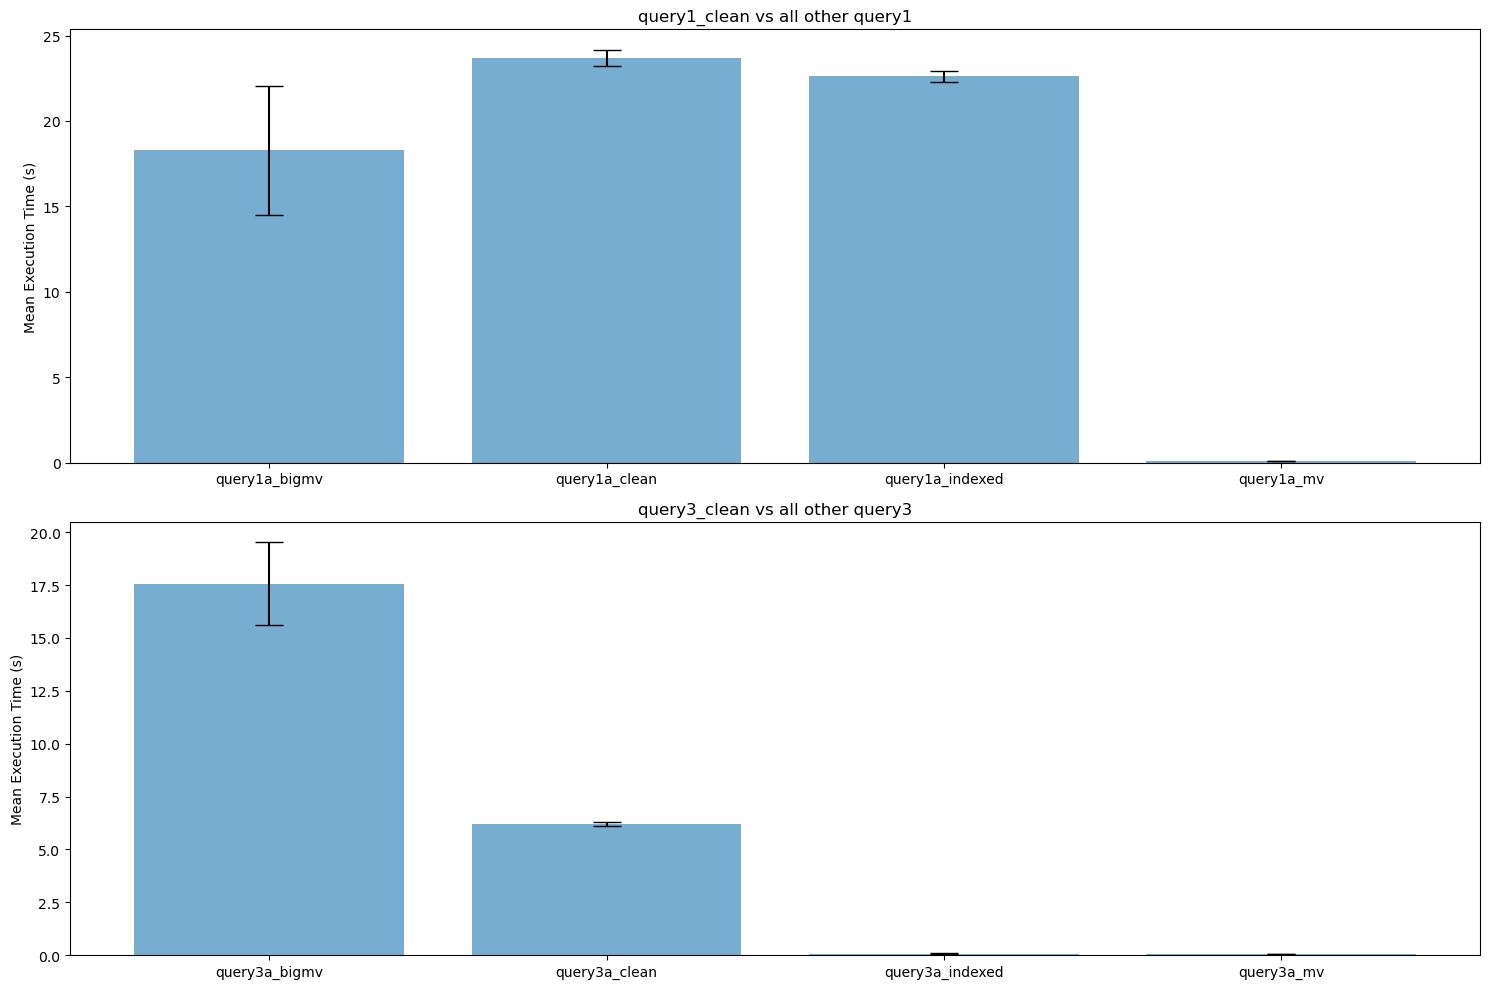

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# query1_clean with all other query1
query1 = [q for q in result.index if 'query1' in q]
axs[0].bar(result.loc[query1].index, result.loc[query1]['real_time'], 
           yerr=result.loc[query1]['real_time_std'], alpha=0.6, capsize=10)
axs[0].set_title('query1_clean vs all other query1')

# query3_clean with all other query3
query3 = [q for q in result.index if 'query3' in q]
axs[1].bar(result.loc[query3].index, result.loc[query3]['real_time'], 
           yerr=result.loc[query3]['real_time_std'], alpha=0.6, capsize=10)
axs[1].set_title('query3_clean vs all other query3')

for ax in axs.flat:
    ax.set(ylabel='Mean Execution Time (s)')

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
import os
import re
import pandas as pd

# Directory path
dir_path = './code/results/res_20240313_173822'

# Initialize an empty DataFrame
df = pd.DataFrame(columns=['filename', 'table', 'number_of_rows', 'table_size_MB', 'index_size_MB'])

# Get a list of all text files
files = [f for f in os.listdir(dir_path) if f.startswith('stat_') and f.endswith('.txt')]

# Regular expression patterns
table_pattern = r'(\w+)\s+\*\*\* Statistics for Table:'
row_pattern = r'Number of rows:\s+(\d+)'
table_size_pattern = r'Table size:\s+(\d+)\s+(MB|kB)'
index_size_pattern = r'Index size:\s+(\d+)\s+(MB|kB)'

# Process each file
for file in files:
    with open(os.path.join(dir_path, file), 'r') as f:
        content = f.read()
        
        # Extract table names and statistics
        tables = re.findall(table_pattern, content)
        number_of_rows_list = [int(x) for x in re.findall(row_pattern, content)]
        table_sizes = [int(x[0]) if x[1] == 'MB' else int(x[0]) / 1024 for x in re.findall(table_size_pattern, content)]
        index_sizes = [int(x[0]) if x[1] == 'MB' else int(x[0]) / 1024 for x in re.findall(index_size_pattern, content)]
        
        # Append to DataFrame
        for table, number_of_rows, table_size, index_size in zip(tables, number_of_rows_list, table_sizes, index_sizes):
            df.loc[len(df)] = [file, table, number_of_rows, table_size, index_size]

df

,filename,table,number_of_rows,table_size_MB,index_size_MB


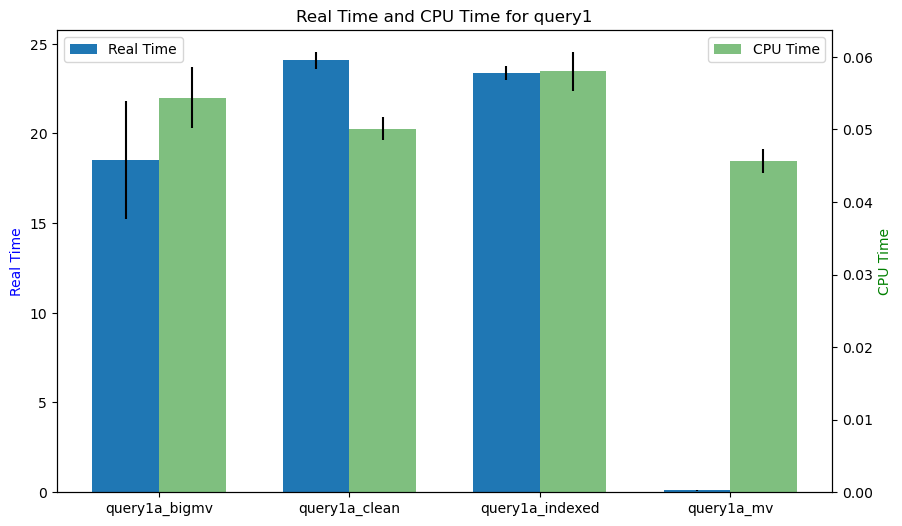

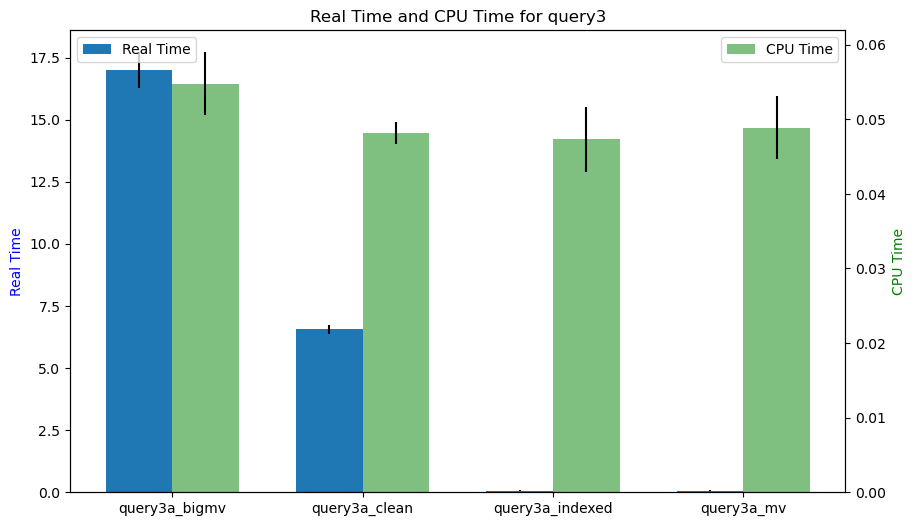

In [26]:
import numpy as np

# Create a barplot with error bars
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
bar_width = 0.35
index = np.arange(len(plot_data1.index))

ax1.bar(index, plot_data1['real_time'], bar_width, yerr=plot_data1['real_time_std'], label='Real Time')
ax2.bar(index + bar_width, plot_data1['cpu_time'], bar_width, yerr=plot_data1['cpu_time_std'], label='CPU Time', alpha=0.5, color='g')

ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(plot_data1.index)
ax1.set_ylabel('Real Time', color='b')
ax2.set_ylabel('CPU Time', color='g')
plt.title('Real Time and CPU Time for query1')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
index = np.arange(len(plot_data3.index))

ax1.bar(index, plot_data3['real_time'], bar_width, yerr=plot_data3['real_time_std'], label='Real Time')
ax2.bar(index + bar_width, plot_data3['cpu_time'], bar_width, yerr=plot_data3['cpu_time_std'], label='CPU Time', alpha=0.5, color='g')

ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(plot_data3.index)
ax1.set_ylabel('Real Time', color='b')
ax2.set_ylabel('CPU Time', color='g')
plt.title('Real Time and CPU Time for query3')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()